## Training
Prepapre dataset with the prepare_dataset notebook, before running this one.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
from time import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import calc_gso_batch
import seaborn as sns
sns.set_style("darkgrid")
import os
try: 
    JOBID = os.environ["SLURM_JOB_ID"]
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # nvidia or apple silicon
    os.makedirs(f"mg_data/{JOBID}", exist_ok=True)
except:
    device = torch.device("mps")
    JOBID = "local"
print(f'device: {device}')

def to_tensor(x, device=torch.device("cpu")): return torch.tensor(x, dtype=torch.float32, device=device)



# Best MSE loss: 0.087

In [2]:
MODEL_SAVE_PATH = f"mg_data/{JOBID}/mg_planet.pth"
HAS_SCREEN = False # for plotting or saving images
EPOCHS = 200
BATCH_SIZE = 128
LEARNING_RATE = 3e-4
GSO_LOSS_RATIO = 0.0
USE_CURRENTS = True
USE_PROFILES = True
USE_MAGNETIC = True
INPUT_SIZE = int(USE_CURRENTS)*14 + int(USE_PROFILES)*202 + int(USE_MAGNETIC)*187
TRAIN_DS_PATH = "data/train_ds.mat" # generated from prepapre_dataset
EVAL_DS_PATH = "data/eval_ds.mat"

- mean current: -10183.76, std current: 34209.11
- mean magnetic: -0.20, std magnetic: 0.58
- mean f_profile: 33.13, std f_profile: 0.28
- mean p_profile: 9654.42, std p_profile: 8788.29

In [3]:
class PlaNetDataset(Dataset):
    def __init__(self, ds_mat_path):
        ds_mat = sio.loadmat(ds_mat_path)
        # output: magnetic flux, transposed (matlab is column-major)
        self.psi = to_tensor(ds_mat["psi"]).view(-1, 1, 64, 64)
        # inputs: radial and vertical position of pixels (for plotting only rn) + currents + measurements + profiles 
        self.rr = to_tensor(ds_mat["rr"]).view(-1,1,64,64) # radial position of pixels (64, 64)
        self.zz = to_tensor(ds_mat["zz"]).view(-1,1,64,64) # vertical position of pixels (64, 64)
        self.currs = ds_mat["currs"] # input currents (n, 14)
        self.magnetic = ds_mat["magnetic"] # input magnetic measurements (n, 187)
        self.f_profile = ds_mat["f_profiles"] # input profiles (n, 101)
        self.p_profile = ds_mat["p_profiles"] # input profiles (n, 101)
        inputs = [] # add the normalized inputs to the list
        # if USE_CURRENTS: inputs.append((to_tensor(self.currs)+10183)/34209) # (n, 14)
        if USE_CURRENTS: inputs.append((to_tensor(self.currs))) # (n, 14)
        # if USE_MAGNETIC: inputs.append((to_tensor(self.magnetic)+0.2)/0.58) # (n, 187)
        if USE_MAGNETIC: inputs.append((to_tensor(self.magnetic))) # (n, 187)
        # if USE_PROFILES: inputs.append(torch.cat(((to_tensor(self.f_profile)-33.13)/0.28, 
        #                                           (to_tensor(self.p_profile)-9654)/8788), 1)) # (n, 202)
        if USE_PROFILES: inputs.append(torch.cat((to_tensor(self.f_profile), to_tensor(self.p_profile)), 1)) # (n, 202)
        self.inputs = torch.cat(inputs, 1) # (n, 403)
    def __len__(self): return len(self.psi)
    def __getitem__(self, idx): return self.inputs[idx], self.psi[idx], self.rr[idx], self.zz[idx]

In [ ]:
# test dataset
ds = PlaNetDataset(EVAL_DS_PATH)
print(f"Dataset length: {len(ds)}")
print(f"Input shape: {ds[0][0].shape}")
print(f"Output shape: {ds[0][1].shape}")

In [5]:
# # MODEL: PlaNet: # upsample convolutional neural network > slower > but smoother
# from torch.nn import Module, Linear, Conv2d, MaxPool2d, BatchNorm2d, ReLU, Sequential, Upsample
# class PlaNet(Module): 
#     def __init__(self):
#         super(PlaNet, self).__init__()
#         self.interp = 'bilinear' # 'nearest' or 'bilinear'
#         self.n = n = 16
#         self.fc = Sequential(
#             Linear(INPUT_SIZE, 8*n),
#             ReLU(),
#             Linear(8*n, 16*n),
#             ReLU(),
#         )
#         self.unconv = Sequential(
#             Upsample(scale_factor=4, mode=self.interp),
#             Conv2d(16*n, 8*n, kernel_size=3, padding=1),
#             ReLU(),
#             BatchNorm2d(8*n), # batch normalization
#             Upsample(scale_factor=2, mode=self.interp),
#             Conv2d(8*n, 4*n, kernel_size=3, padding=1),
#             ReLU(),
#             Upsample(scale_factor=2, mode=self.interp),
#             Conv2d(4*n, 2*n, kernel_size=3, padding=1),
#             ReLU(),
#             Upsample(scale_factor=2, mode=self.interp),
#             Conv2d(2*n, n, kernel_size=3, padding=1),
#             ReLU(),
#             Upsample(scale_factor=2, mode=self.interp),
#             Conv2d(n, 1, kernel_size=3, padding=1),
#         )
#     def forward(self, x):
#         x = self.fc(x)
#         x = x.view(-1, 16*self.n, 1, 1)
#         x = self.unconv(x)
#         # x = x.view(-1, 64, 64)
#         return x

In [6]:
# MODEL: PlaNet: # Paper net: branch + trunk conenction and everything
from torch.nn import Module, Linear, Conv2d, MaxPool2d, BatchNorm2d, ReLU, Sequential, Upsample
class PlaNet(Module): # Paper net: branch + trunk conenction and everything
    from torch.nn import Linear, Conv2d, MaxPool2d, BatchNorm2d, ReLU
    def __init__(self):
        super(PlaNet, self).__init__()
        af = ReLU() # activation function
        #branch
        self.branch = Sequential(
            Linear(INPUT_SIZE, 256), af,
            Linear(256, 128), af,
            Linear(128, 64), af
        )
        #trunk
        # def trunk_block(): # faster
        #     return  Sequential(
        #         Conv2d(1, 8, kernel_size=3, stride=2, padding=1), 
        #         BatchNorm2d(8), 
        #         ReLU(),
        #         Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
        #         BatchNorm2d(16), 
        #         ReLU(),
        #         Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        #         BatchNorm2d(32),
        #         ReLU(),
        #     )
        def trunk_block(): 
            return  Sequential(
                Conv2d(1, 8, kernel_size=3, stride=1, padding=1),  BatchNorm2d(8),  af, MaxPool2d(2),
                Conv2d(8, 16, kernel_size=3, stride=1, padding=1), BatchNorm2d(16),  af, MaxPool2d(2),
                Conv2d(16, 32, kernel_size=3, stride=1, padding=1), BatchNorm2d(32), af, MaxPool2d(2),
            )
        self.trunk_r, self.trunk_z = trunk_block(), trunk_block()
        self.trunk_fc = Sequential(
            Linear(2*32*8*8, 128), af,
            Linear(128, 64), af,
            Linear(64, 64), af,
        )
        # head
        self.fc = Sequential(Linear(64, 2048), af)
        self.anti_conv = Sequential(
            Upsample(scale_factor=2, mode='bilinear'), Conv2d(32, 32, kernel_size=3, padding=1), BatchNorm2d(32), af, #NOTE: 32, not 64, paper inconsistency
            Upsample(scale_factor=2, mode='bilinear'), Conv2d(32, 16, kernel_size=3, padding=1), BatchNorm2d(16), af,
            Upsample(scale_factor=2, mode='bilinear'), Conv2d(16, 8, kernel_size=3, padding=1), BatchNorm2d(8), af,
            Conv2d(8, 1, kernel_size=3, padding=1)
        )
        
    def forward(self, x):
        xb, r, z = x
        #branch net
        xb = self.branch(xb)
        #trunk net
        r, z = self.trunk_r(r), self.trunk_z(z) # convolutions
        r, z = r.view(-1, 32*8*8), z.view(-1, 32*8*8) # flatten
        xt = torch.cat((r, z), 1) # concatenate
        xt = self.trunk_fc(xt) # fully connected
        # multiply trunk and branch
        x = xt * xb
        #head net
        x = self.fc(x)
        x = x.view(-1, 32, 8, 8)
        x = self.anti_conv(x)
        return x

In [ ]:
x = (torch.rand(1, INPUT_SIZE), torch.rand(1, 1, 64, 64), torch.rand(1, 1, 64, 64))
net = PlaNet()
y = net(x)
print(f"in: {[x.shape for x in x]}, out: {y.shape}")

n_sampl = 7
nx = (torch.rand(n_sampl, INPUT_SIZE), torch.rand(n_sampl, 1, 64, 64), torch.rand(n_sampl, 1, 64, 64))
ny = net(nx)
print(f"in: {[x.shape for x in nx]}, out: {ny.shape}")


## Training

In [ ]:
train_ds, val_ds = PlaNetDataset(TRAIN_DS_PATH), PlaNetDataset(EVAL_DS_PATH) # initialize datasets
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
model = PlaNet()  # instantiate model
model.to(device) # move model to device
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss
best_loss = float('inf') # initialize best loss
start_time = time() # start time
for ep in range(EPOCHS): 
    epoch_time = time()
    model.train()
    trainloss, evalloss = [], []
    for input_currs, psi, rr, zz in train_dl:
        input_currs, psi, rr, zz = input_currs.to(device), psi.to(device), rr.to(device), zz.to(device) # move to device
        optimizer.zero_grad()
        psi_pred = model((input_currs, rr, zz))
        gso, gso_pred = calc_gso_batch(psi, rr, zz, dev=device), calc_gso_batch(psi_pred, rr, zz, dev=device)
        mse_loss = loss_fn(psi_pred, psi) # mean squared error loss on psi
        gso_loss = loss_fn(gso_pred, gso) # PINN loss on grad shafranov
        loss = (1-GSO_LOSS_RATIO)*mse_loss + GSO_LOSS_RATIO*gso_loss # total loss
        loss.backward()
        optimizer.step()
        trainloss.append((loss.item(), mse_loss.item(), gso_loss.item()))
    model.eval()
    with torch.no_grad():
        for input_currs, psi, rr, zz in val_dl:
            input_currs, psi, rr, zz = input_currs.to(device), psi.to(device), rr.to(device), zz.to(device)
            psi_pred = model((input_currs, rr, zz))
            gso, gso_pred = calc_gso_batch(psi, rr, zz, dev=device), calc_gso_batch(psi_pred, rr, zz, dev=device)
            mse_loss = loss_fn(psi_pred, psi)
            gso_loss = loss_fn(gso_pred, gso)
            loss = (1-GSO_LOSS_RATIO)*mse_loss + GSO_LOSS_RATIO*gso_loss # total loss
            evalloss.append((loss.item(), mse_loss.item(), gso_loss.item()))
    ttot_loss, tmse_loss, tgso_loss = map(lambda x: sum(x)/len(x), zip(*trainloss))
    etot_loss, emse_loss, egso_loss = map(lambda x: sum(x)/len(x), zip(*evalloss))
    if etot_loss < best_loss: # check if improved
        best_loss = etot_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        endp = " new best\n"
    else: endp = "\n" 
    print(f"Ep {ep+1}/{EPOCHS}: Train Loss: {ttot_loss:.4f}, mse {tmse_loss:.4f}, gso {tgso_loss:.4f}  |  " +
          f"Eval Loss: {etot_loss:.4f}, mse {emse_loss:.4f}, gso {egso_loss:.4f}  |  t:{time()-epoch_time:.2f}s,", end=endp)
print(f"Training time: {time()-start_time:.2f}s")
print(f"Best val loss: {best_loss:.4f}")

NameError: name 'JOBID' is not defined

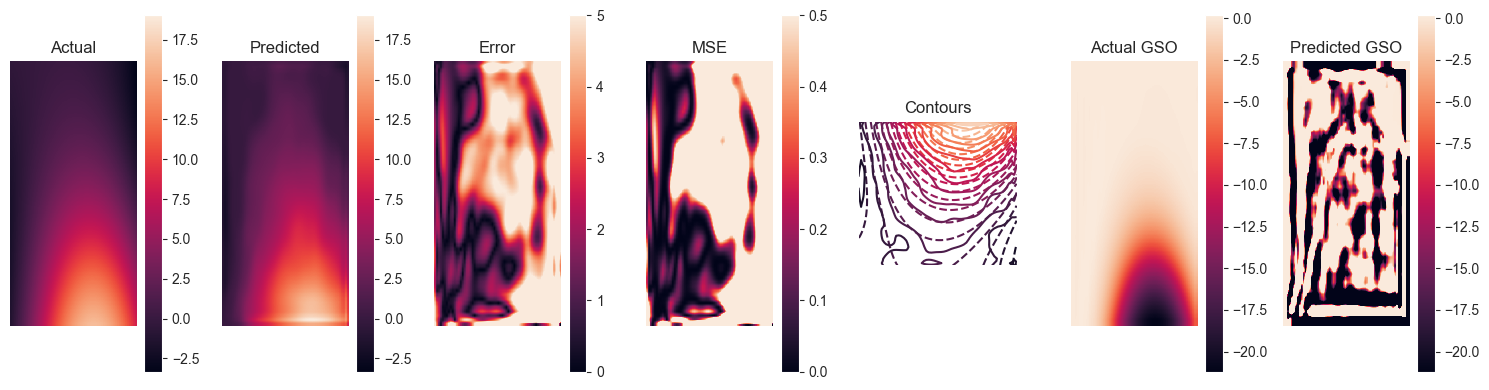

In [12]:
# testing network output
model = PlaNet()
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()
ds = PlaNetDataset(EVAL_DS_PATH)
# ds = PlaNetDataset(TRAIN_DS_PATH)
for i in np.random.randint(0, len(ds), 10):  
    fig, axs = plt.subplots(1, 7, figsize=(15, 4))
    input_currs, psi_ds, rr, zz = ds[i]
    input_currs, psi_ds, rr, zz = input_currs.view(1,-1), psi_ds.view(1,1,64,64), rr.view(1,1,64,64), zz.view(1,1,64,64)
    psi_pred = model((input_currs, rr, zz))
    gso, gso_pred = calc_gso_batch(psi_ds, rr, zz), calc_gso_batch(psi_pred, rr, zz)
    gso, gso_pred = gso.detach().numpy().reshape(64, 64), gso_pred.detach().numpy().reshape(64, 64)
    gso_range = (gso.max(), gso.min())
    psi_pred = psi_pred.detach().numpy().reshape(64, 64)
    psi_ds = psi_ds.detach().numpy().reshape(64, 64)
    rr, zz = rr.view(64, 64).detach().numpy(), zz.view(64, 64).detach().numpy()
    ext = [ds.rr.min(), ds.rr.max(), ds.zz.min(), ds.zz.max()]
    bmin, bmax = np.min([psi_ds, psi_pred]), np.max([psi_ds, psi_pred])
    err = np.abs(psi_ds - psi_pred)*100/abs(bmax - bmin)
    # err = np.abs(psi_ds - psi_pred)*100/abs((psi_ds + psi_pred)/2)
    err_mse = (psi_ds - psi_pred)**2

    im0 = axs[0].imshow(psi_ds, extent=ext, vmin=bmin, vmax=bmax)
    axs[0].set_title("Actual")
    axs[0].set_aspect('equal')
    fig.colorbar(im0, ax=axs[0]) 

    im1 = axs[1].imshow(psi_pred, extent=ext, vmin=bmin, vmax=bmax)
    axs[1].set_title("Predicted")
    axs[1].set_aspect('equal')
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(err, extent=ext, vmin=0, vmax=5)
    axs[2].set_title("Error")
    axs[2].set_aspect('equal')
    fig.colorbar(im2, ax=axs[2])

    im3 = axs[3].imshow(err_mse, extent=ext, vmin=0, vmax=0.5)
    axs[3].set_title("MSE")
    axs[3].set_aspect('equal')
    fig.colorbar(im3, ax=axs[3])

    c0 = axs[4].contour(rr, zz, psi_ds, levels=20, linestyles='dashed')
    c1 = axs[4].contour(rr, zz, psi_pred, levels=20)
    axs[4].set_title("Contours")
    axs[4].set_aspect('equal')

    im5 = axs[5].imshow(gso, extent=ext, vmin=gso_range[1], vmax=gso_range[0])
    axs[5].set_title("Actual GSO")
    axs[5].set_aspect('equal')
    fig.colorbar(im5, ax=axs[5])

    im6 = axs[6].imshow(gso_pred, extent=ext, vmin=gso_range[1], vmax=gso_range[0])
    axs[6].set_title("Predicted GSO")
    axs[6].set_aspect('equal')
    fig.colorbar(im6, ax=axs[6])

    for ax in axs: ax.axis('off')

    plt.tight_layout()
    plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/planet_{i}.png")